# Lista 02

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import norm

3. Utilize o dataset lalonde visto no exemplo da aula 02 e implemente o FRT utilizando a estatística _t_ studentizada e a estatística de soma de postos de Wilcoxon. Compare os _p-valores_ obtidos com suas versões asintóticas.

In [2]:
def get_lalonde(version='R'):
    if version.lower() == 'online':
        column_names = ['treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75', 're78']
        df_treated = pd.read_csv(r'..\Lista01\nswre74_treated.txt', names=column_names, sep=r"\s+|;|:|,", engine='python')
        df_control = pd.read_csv(r'..\Lista01\nswre74_control.txt', names=column_names, sep=r"\s+|;|:|,", engine='python')
        lalonde = pd.concat ([df_treated, df_control])
        lalonde = lalonde.reset_index(drop=True)
    elif version.lower() == 'peng':
        lalonde = pd.read_csv(r'..\Lista01\cps1re74.csv', sep=r"\s+|;|:|,", engine='python')
    elif version.lower() == 'r':
        lalonde = pd.read_csv(r'.\R\Lalonde.csv', sep=r"\s+|;|:|,", engine='python')
    else:
        raise ValueError(f'{version} is not a valid option.')

    lalonde['treat'] = lalonde['treat'].astype(int)
    lalonde['u74'] = (lalonde['re74'] == 0).astype(int)
    lalonde['u75'] = (lalonde['re75'] == 0).astype(int)

    new_column_names = ["treat", "age", "educ", "black", "hispan", "married", "nodegree", "re74", "re75", "u74", "u75", "re78"]
    return lalonde.reindex(columns=new_column_names)

In [3]:
lalonde = get_lalonde('r')
n1 = lalonde['treat'].sum()
n0 = (1-lalonde['treat']).sum()
n = n1 + n0
print(f'n1 = {n1}, n0 = {n0}, n = {n}')

n1 = 185, n0 = 260, n = 445


In [9]:
def tau_hat(y1, y0):
    return y1.mean() - y0.mean()

def tau_hat_normal(y1, y0):
    s2 = np.var(np.concatenate((y1,y0)), ddof=1)
    alfa = np.sqrt(n/(n1*n0) * s2)
    return tau_hat(y1,y0) / alfa

def studentized(y1, y0):
    s2_1 = np.var(y1, ddof=1)
    s2_0 = np.var(y0, ddof=1)
    dif_means = tau_hat(y1,y0)
    return dif_means / np.sqrt(s2_1 / n1 + s2_0/n0)

def wilcoxon(y, z):
    r = []
    for i in range(len(y)):
        r.append((y.values <= y.values[i]).sum())
    r_avg_rank = []
    for i in range(len(r)):
        rep = sum(1 for x in r if x==r[i]) - 1
        r_avg_rank.append(r[i] - rep/2)
    r = pd.Series(r_avg_rank)
    return r.dot(z) - n1*(n+1)/2

def wilcoxon_normal(y, z):
    w = wilcoxon(y,z)
    alfa = n1*n0*(n+1)/12
    return w / np.sqrt(alfa)

In [12]:
y1 = lalonde['re78'][lalonde['treat']==1]
y0 = lalonde['re78'][lalonde['treat']==0]

print(f'y1 mean = {y1.mean():.2f}')
print(f'y0 mean = {y0.mean():.2f}')


tau_hat_ = tau_hat(y1,y0)
tau_hat_normal_ = tau_hat_normal(y1,y0)
t_student_ = studentized(y1,y0)
wilcoxon_ = wilcoxon(lalonde['re78'], lalonde['treat'])
wilcoxon_normal_ = wilcoxon_normal(lalonde['re78'], lalonde['treat'])

print(f'tau_hat = {tau_hat_:.2f}')
print(f'tau_hat_normal = {tau_hat_normal_:.4f}')
print(f't_student = {t_student_:.4f}')
print(f'W = {wilcoxon_}')
print(f'W_normal = {wilcoxon_normal_}')

y1 mean = 6349.15
y0 mean = 4554.80
tau_hat = 1794.34
tau_hat_normal = 2.8131
t_student = 2.6741
W = 3352.5
W_normal = 2.5073758696334


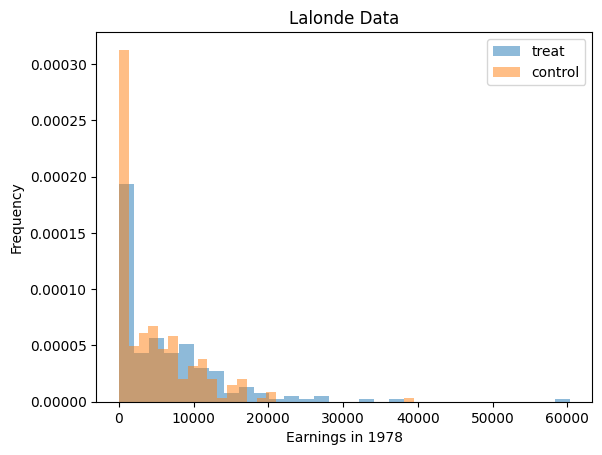

In [11]:
plt.hist(y1, bins=30, alpha=0.5, label='treat', density=True)
plt.hist(y0, bins=30, alpha=0.5, label='control', density=True)
plt.xlabel('Earnings in 1978')
plt.ylabel('Frequency')
plt.title('Lalonde Data')
plt.legend()
plt.show()

In [22]:
mc = 10000
tau_hat_list = []
t_student_list = []
wilcoxon_list = []
z_random = lalonde['treat'].copy()
for i in range(mc):
    random.shuffle(z_random)

    y1_ = lalonde['re78'][z_random==1]
    y0_ = lalonde['re78'][z_random==0]

    tau_hat_list.append(tau_hat(y1_,y0_))
    t_student_list.append(studentized(y1_,y0_))
    wilcoxon_list.append(wilcoxon(lalonde['re78'], z_random))

tau_hat_p_value = sum([1 for t in tau_hat_list if tau_hat_ < t]) / mc
t_student_p_value = sum([1 for t in t_student_list if t_student_ < t]) / mc
wilcoxon_p_value = sum([1 for w in wilcoxon_list if wilcoxon_ < w]) / mc

In [29]:
print('MC p-value')
print(f'  tau_hat: {tau_hat_p_value:.4f}')
print(f'  t-student: {t_student_p_value:.4f}')
print(f'  Wilcoxon: {wilcoxon_p_value:.4f}')

MC p-value
  tau_hat: 0.0026
  t-student: 0.0030
  Wilcoxon: 0.0049


In [31]:
print('Asymptotic p-value')
print(f'  tau_hat: {1-norm.cdf(tau_hat_normal_):.4f}')
print(f'  t-student: {1-norm.cdf(t_student_):.4f}')
print(f'  Wilcoxon: {1-norm.cdf(wilcoxon_normal_):.4f}')

Asymptotic p-value
  tau_hat: 0.0025
  t-student: 0.0037
  Wilcoxon: 0.0061


4. Faça um estudo de simulacão e compare $p_{FRT}$, $\hat{𝑝}_{𝐹𝑅𝑇}$ e $\tilde{𝑝}_{𝐹𝑅𝑇} = (1+𝑅)^{−1} \sum{}^R_{r=1} I(T(z^r,Y) \geq{} T(Z,Y))$ (utilize diversos valores de 𝑅).

In [14]:
z_random = lalonde['treat'].copy()
z_random

0      1
1      1
2      1
3      1
4      1
      ..
440    0
441    0
442    0
443    0
444    0
Name: treat, Length: 445, dtype: int32

In [18]:
random.shuffle(z_random)

In [19]:
z_random

0      0
1      0
2      1
3      0
4      0
      ..
440    1
441    0
442    0
443    1
444    0
Name: treat, Length: 445, dtype: int32